In [93]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import keras as ks
import tensorflow as tf
import pickle
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import keras
import random
import numpy as np
import os
from PIL import Image

In [2]:
!pip install -q -U tensorflow-addons

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_label, class_name in enumerate(sorted(os.listdir(folder))):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = Image.open(img_path)
            img = img.resize((28, 28))  # Resize the image to match MNIST size
            img = np.array(img)
            if img is not None:
                images.append(img)
                labels.append(class_label)
    return np.array(images), np.array(labels)

# Assuming your dataset is stored in a folder called 'dataset'
dataset_folder = '/kaggle/input/paddydoctormedium'

# Load images and labels from the dataset folder
x_data, y_data = load_images_from_folder(dataset_folder)

# Shuffle the data
random_indices = np.random.permutation(len(x_data))
x_data = x_data[random_indices]
y_data = y_data[random_indices]

# Split the data into training and testing sets (assuming 80-20 split)
split_idx = int(0.8 * len(x_data))
x_train, x_test = x_data[:split_idx], x_data[split_idx:]
y_train, y_test = y_data[:split_idx], y_data[split_idx:]

# Normalize the pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Print dataset shapes
print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (12980, 2352)
Testing data shape: (3245, 2352)
Training labels shape: (12980,)
Testing labels shape: (3245,)


In [22]:
x_train = x_train.astype('float32')
x_train /= 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [23]:
class Pairs:
  def makePairs(self, x, y):
    num_classes = 13
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = list()
    labels = list()

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        labels += list([1])
        pairs += [[x1, x2]]
    
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        labels += list([0])
        pairs += [[x1, x2]]
        
    return np.array(pairs), np.array(labels)

In [24]:
p = Pairs()

In [25]:
pairs_train, labels_train = p.makePairs(x_train, y_train)
pairs_test, labels_test = p.makePairs(x_test, y_test)
labels_train = labels_train.astype('float32')
labels_test = labels_test.astype('float32')

In [32]:
def euclideanDistance(v):
    x, y = v
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_original, y_pred):
    sqaure_pred = K.square(y_pred)
    margin = 1.0  # Ensure margin is a float
    margin_square = K.square(K.maximum(0.0, margin - y_pred))
    return K.mean(y_original * sqaure_pred + (1 - y_original) * margin_square)

def compute_accuracy(y_original, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_original)

def accuracy(y_original, y_pred):
    return K.mean(K.equal(y_original, K.cast(y_pred < 0.5, y_original.dtype)))

In [94]:
input = Input(shape=(2352,))
x = Flatten()(input)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1, name="first_dropout")(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1, name="second_dropout")(x)
x = Dense(256, activation='relu')(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
dense = Model(input, x)


input1 = Input(shape=(2352,))
input2 = Input(shape=(2352,))
dense1 = dense(input1)
dense2 = dense(input2)

distance = Lambda(euclideanDistance, output_shape=eucl_dist_output_shape)([dense1, dense2])
model = Model([input1, input2], distance)

In [95]:
model.compile(loss = contrastive_loss, optimizer="adam", metrics=[accuracy])
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_19       │ (None, 256)       │    191,936 │ input_layer_17[0… │
│ (Functional)        │                   │            │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, 1)         │          0 │ functional_19[0]… │
│                     │                   │            │ functional_19[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 191,936 (749.75 KB)

 Trainable params: 191,936 (749.75 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=64, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))


Epoch 1/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5022 - loss: 0.2166 - val_accuracy: 0.5000 - val_loss: 0.2280
Epoch 2/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5018 - loss: 0.2173 - val_accuracy: 0.5000 - val_loss: 0.2287
Epoch 3/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5024 - loss: 0.2167 - val_accuracy: 0.5000 - val_loss: 0.2297
Epoch 4/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5019 - loss: 0.2130 - val_accuracy: 0.5000 - val_loss: 0.2367
Epoch 5/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5030 - loss: 0.2184 - val_accuracy: 0.5000 - val_loss: 0.2279
Epoch 6/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5035 - loss: 0.2126 - val_accuracy: 0.5000 - val_loss: 0.2235
Epoch 7/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5019 - loss: 0.2117 - val_accuracy: 0.5000 - val_loss: 0.2361
Epoch 8/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5014 - loss: 0.2119 - val_accuracy: 0.

In [104]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)
print("Accuracy on test set:", te_acc*100)

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy on test set: 63.543913713405246


# **BatchSize = 32**

In [105]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=32, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))


Epoch 1/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5060 - loss: 0.2169 - val_accuracy: 0.5000 - val_loss: 0.2356
Epoch 2/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5048 - loss: 0.2134 - val_accuracy: 0.5000 - val_loss: 0.2479
Epoch 3/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5045 - loss: 0.2125 - val_accuracy: 0.5000 - val_loss: 0.2282
Epoch 4/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5036 - loss: 0.2132 - val_accuracy: 0.5000 - val_loss: 0.2283
Epoch 5/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5059 - loss: 0.2102 - val_accuracy: 0.5000 - val_loss: 0.2266
Epoch 6/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5049 - loss: 0.2095 - val_accuracy: 0.5000 - val_loss: 0.2391
Epoch 7/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5047 - loss: 0.2136 - val_accuracy: 0.5000 - val_loss: 0.2290
Epoch 8/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5040 - loss: 0.2088 - val_accuracy: 0.

In [106]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)
print("Accuracy on test set:", te_acc*100)

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy on test set: 63.281972265023114


# **batch size = 128**

In [107]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))


Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5011 - loss: 0.2023 - val_accuracy: 0.5000 - val_loss: 0.2202
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5011 - loss: 0.2005 - val_accuracy: 0.5000 - val_loss: 0.2223
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5013 - loss: 0.1988 - val_accuracy: 0.5000 - val_loss: 0.2254
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5008 - loss: 0.1986 - val_accuracy: 0.5000 - val_loss: 0.2204
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5020 - loss: 0.2005 - val_accuracy: 0.5000 - val_loss: 0.2190
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5016 - loss: 0.2019 - val_accuracy: 0.5000 - val_loss: 0.2216
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5017 - loss: 0.1989 - val_accuracy: 0.5000 - val_loss: 0.2188
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5015 - loss: 0.1987 - val_accuracy: 0.

In [108]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)
print("Accuracy on test set:", te_acc*100)

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy on test set: 63.281972265023114


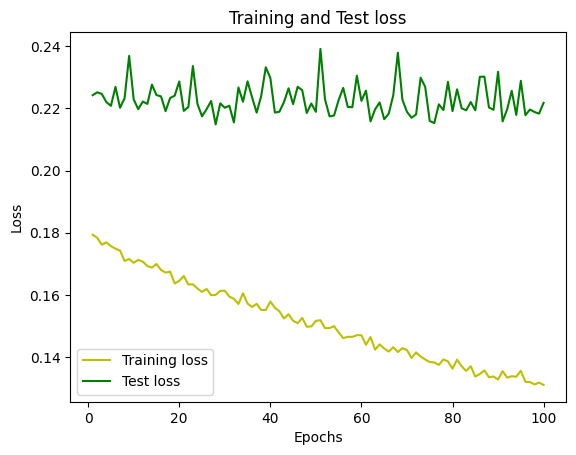

In [47]:

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Regularized Cross Entropy

In [67]:
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=[accuracy])
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ (None, 256)       │    191,936 │ input_layer_13[0… │
│ (Functional)        │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 1)         │          0 │ functional_15[0]… │
│                     │                   │            │ functional_15[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 191,936 (749.75 KB)

 Trainable params: 191,936 (749.75 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


 62/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5022 - loss: 6.0104e-08

W0000 00:00:1711645629.173216      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5035 - loss: 5.9512e-08

W0000 00:00:1711645630.590066      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711645631.479862      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5035 - loss: 5.9512e-08 - val_accuracy: 0.5000 - val_loss: 5.9605e-08
Epoch 2/10
 66/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5030 - loss: 5.9037e-08

W0000 00:00:1711645631.951043      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5029 - loss: 5.9363e-08 - val_accuracy: 0.5000 - val_loss: 5.9605e-08
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5033 - loss: 5.9069e-08 - val_accuracy: 0.5000 - val_loss: 5.9605e-08
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5024 - loss: 5.9106e-08 - val_accuracy: 0.5000 - val_loss: 5.9605e-08
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5023 - loss: 5.9653e-08 - val_accuracy: 0.5000 - val_loss: 5.9605e-08
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: 5.9115e-08 - val_accuracy: 0.5000 - val_loss: 5.9605e-08
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: 5.9218e-08 - val_accuracy: 0.5000 - val_loss: 5.9605e-08
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5027 - loss: 5.9403e-08 - val_accuracy: 0.5000 - val_loss: 5.9605e-08
Epoch 9/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accur

In [69]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

 90/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1711645690.306885      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1711645690.909987      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [70]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 65.17719568567027


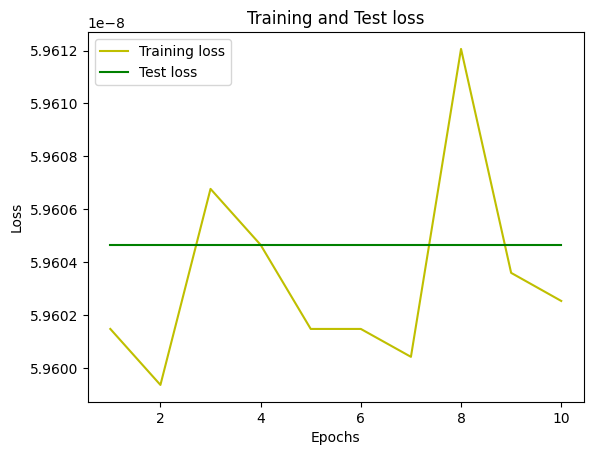

In [71]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# RMSPROP Optimizer

In [72]:
model.compile(loss = contrastive_loss, optimizer="RMSprop", metrics=[accuracy])
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ (None, 256)       │    191,936 │ input_layer_13[0… │
│ (Functional)        │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 1)         │          0 │ functional_15[0]… │
│                     │                   │            │ functional_15[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 191,936 (749.75 KB)

 Trainable params: 191,936 (749.75 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))


Epoch 1/10
 66/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5008 - loss: 0.1551

W0000 00:00:1711645810.936518      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5019 - loss: 0.1446

W0000 00:00:1711645812.217221      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711645812.967519      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5019 - loss: 0.1446 - val_accuracy: 0.5000 - val_loss: 0.2224
Epoch 2/10
 66/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5022 - loss: 0.1332

W0000 00:00:1711645813.331889      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5025 - loss: 0.1347 - val_accuracy: 0.5000 - val_loss: 0.2354
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5021 - loss: 0.1372 - val_accuracy: 0.5000 - val_loss: 0.2260
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5021 - loss: 0.1356 - val_accuracy: 0.5000 - val_loss: 0.2293
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5030 - loss: 0.1341 - val_accuracy: 0.5000 - val_loss: 0.2469
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5020 - loss: 0.1337 - val_accuracy: 0.5000 - val_loss: 0.2181
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5029 - loss: 0.1355 - val_accuracy: 0.5000 - val_loss: 0.2219
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5021 - loss: 0.1347 - val_accuracy: 0.5000 - val_loss: 0.2199
Epoch 9/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5021 - loss: 0.1337 - val_accuracy: 0.5000 - val_

In [74]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

 89/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1711645831.785211      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1711645832.387376      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [75]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 65.46995377503852


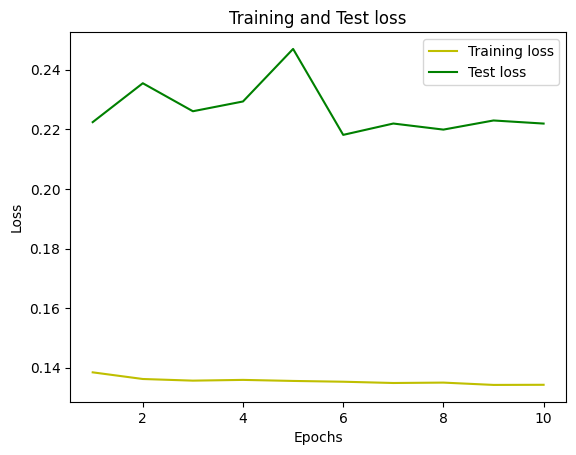

In [76]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Mini Batch Gradient Descent Optimizer

In [77]:
model.compile(loss = contrastive_loss, optimizer="SGD", metrics=[accuracy])
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ (None, 256)       │    191,936 │ input_layer_13[0… │
│ (Functional)        │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 1)         │          0 │ functional_15[0]… │
│                     │                   │            │ functional_15[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 191,936 (749.75 KB)

 Trainable params: 191,936 (749.75 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))


Epoch 1/10
 64/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5063 - loss: 0.2080

W0000 00:00:1711645887.514381      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5035 - loss: 0.2021

W0000 00:00:1711645888.726364      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711645889.479745      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5035 - loss: 0.2021 - val_accuracy: 0.5000 - val_loss: 0.2399
Epoch 2/10
 70/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5026 - loss: 0.1826

W0000 00:00:1711645889.812436      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5024 - loss: 0.1858 - val_accuracy: 0.5000 - val_loss: 0.2246
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5013 - loss: 0.1711 - val_accuracy: 0.5000 - val_loss: 0.2320
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5027 - loss: 0.1643 - val_accuracy: 0.5000 - val_loss: 0.2272
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5020 - loss: 0.1694 - val_accuracy: 0.5000 - val_loss: 0.2258
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5014 - loss: 0.1699 - val_accuracy: 0.5000 - val_loss: 0.2281
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5021 - loss: 0.1638 - val_accuracy: 0.5000 - val_loss: 0.2349
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5014 - loss: 0.1636 - val_accuracy: 0.5000 - val_loss: 0.2247
Epoch 9/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5013 - loss: 0.1667 - val_accuracy: 0.5000 - val_

In [79]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

 81/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1711645899.238060      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1711645899.893005      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [80]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 63.18952234206472


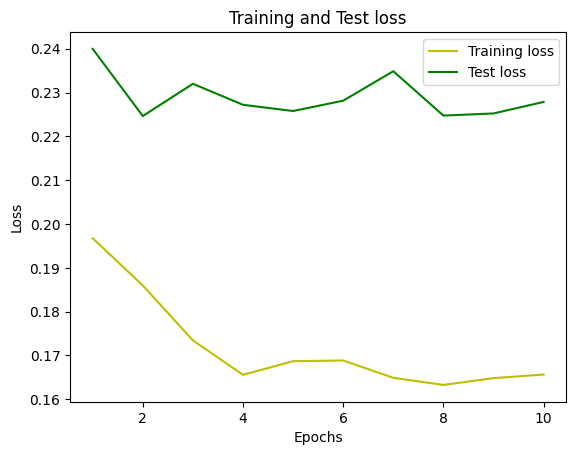

In [81]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Adam Optimizer

In [82]:
model.compile(loss = contrastive_loss, optimizer="adam", metrics=[accuracy])
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ (None, 256)       │    191,936 │ input_layer_13[0… │
│ (Functional)        │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 1)         │          0 │ functional_15[0]… │
│                     │                   │            │ functional_15[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 191,936 (749.75 KB)

 Trainable params: 191,936 (749.75 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))


Epoch 1/10
 64/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5025 - loss: 0.1308

W0000 00:00:1711645945.222298      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5024 - loss: 0.1292

W0000 00:00:1711645946.374790      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711645947.108835      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5024 - loss: 0.1292 - val_accuracy: 0.5000 - val_loss: 0.2209
Epoch 2/10
 41/203 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5037 - loss: 0.1230

W0000 00:00:1711645947.444922      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: 0.1246 - val_accuracy: 0.5000 - val_loss: 0.2180
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5030 - loss: 0.1229 - val_accuracy: 0.5000 - val_loss: 0.2193
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: 0.1220 - val_accuracy: 0.5000 - val_loss: 0.2155
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5022 - loss: 0.1226 - val_accuracy: 0.5000 - val_loss: 0.2254
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5035 - loss: 0.1210 - val_accuracy: 0.5000 - val_loss: 0.2210
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5020 - loss: 0.1245 - val_accuracy: 0.5000 - val_loss: 0.2188
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5026 - loss: 0.1207 - val_accuracy: 0.5000 - val_loss: 0.2187
Epoch 9/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5025 - loss: 0.1214 - val_accuracy: 0.5000 - val_

In [84]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

 91/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1711645953.981897      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1711645954.594701      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [85]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 66.61016949152543


# Hyper Parameter Optimization

In [86]:
opt = ks.optimizers.Adam(learning_rate=0.0005, beta_1=0.888, beta_2=0.8888, epsilon=1e-8)


In [87]:
model.compile(loss = contrastive_loss, optimizer=opt, metrics=[accuracy])
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 2352)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ (None, 256)       │    191,936 │ input_layer_13[0… │
│ (Functional)        │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 1)         │          0 │ functional_15[0]… │
│                     │                   │            │ functional_15[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 191,936 (749.75 KB)

 Trainable params: 191,936 (749.75 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))


Epoch 1/10
 64/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5030 - loss: 0.1160

W0000 00:00:1711646050.392560      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5028 - loss: 0.1162

W0000 00:00:1711646051.777835      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711646052.504912      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5028 - loss: 0.1162 - val_accuracy: 0.5000 - val_loss: 0.2169
Epoch 2/10
 63/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5018 - loss: 0.1153

W0000 00:00:1711646052.842166      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5020 - loss: 0.1159 - val_accuracy: 0.5000 - val_loss: 0.2174
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5024 - loss: 0.1152 - val_accuracy: 0.5000 - val_loss: 0.2211
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5029 - loss: 0.1132 - val_accuracy: 0.5000 - val_loss: 0.2245
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5024 - loss: 0.1142 - val_accuracy: 0.5000 - val_loss: 0.2194
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5030 - loss: 0.1120 - val_accuracy: 0.5000 - val_loss: 0.2222
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5026 - loss: 0.1137 - val_accuracy: 0.5000 - val_loss: 0.2244
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5033 - loss: 0.1149 - val_accuracy: 0.5000 - val_loss: 0.2184
Epoch 9/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5033 - loss: 0.1159 - val_accuracy: 0.5000 - val_

In [89]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

 91/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1711646062.026053      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1711646062.628951      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [90]:
print("Accuracy on test set:", te_acc*100)


Accuracy on test set: 66.10169491525424


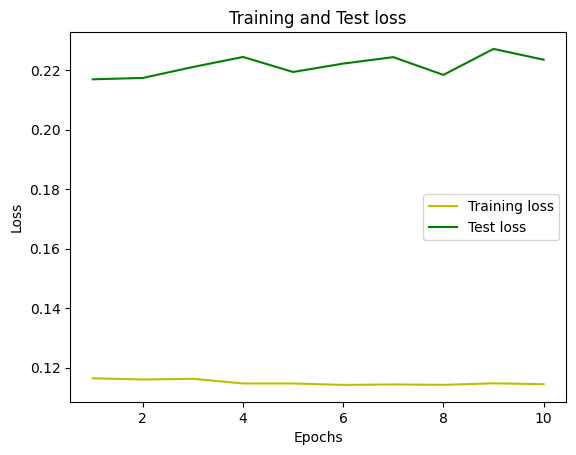

In [91]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
     